<a href="https://colab.research.google.com/github/Sanket71/LSTM-Projects/blob/main/NLP_using_CNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix,precision_score,f1_score,recall_score,accuracy_score

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding,Conv1D,MaxPooling1D,BatchNormalization,LSTM,Flatten,Concatenate, Dense, Dropout

from tqdm import tqdm
tqdm.pandas()
from collections import Counter

In [ ]:
df=pd.read_csv("./Training_Essay_Data.csv")
print(df.shape)
df.head()

(29145, 2)


,text,generated
0,Car-free cities have become a subject of incre...,1
1,"Car Free Cities Car-free cities, a concept ga...",1
2,A Sustainable Urban Future Car-free cities ...,1
3,Pioneering Sustainable Urban Living In an e...,1
4,The Path to Sustainable Urban Living In an ...,1


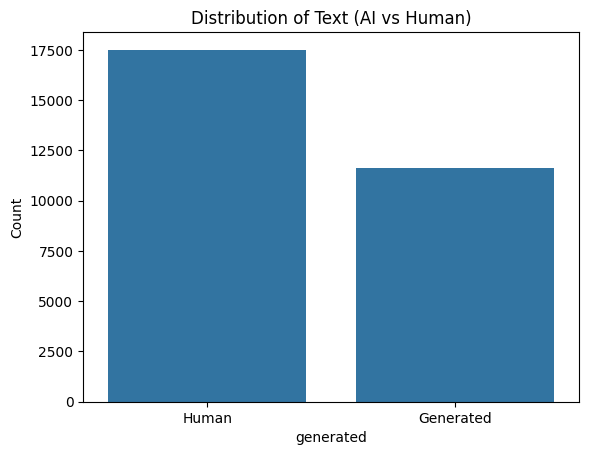

Count of Human vs Generated text:
generated
0    17508
1    11637
Name: count, dtype: int64


In [ ]:
# Plot the distribution of the 'generated & Humans' labels
ax = sns.countplot(x=df['generated'])
plt.title('Distribution of Text (AI vs Human)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Human', 'Generated'])
plt.show()

# Print the count
generated_count = df['generated'].value_counts()
print(f"Count of Human vs Generated text:\n{generated_count}")

In [ ]:
# length of the longest and smallest text
print(f"Length of the longest text: {df['text'].str.len().max()}")
print(f"Length of the smallest text: {df['text'].str.len().min()}")

Length of the longest text: 9157
Length of the smallest text: 1


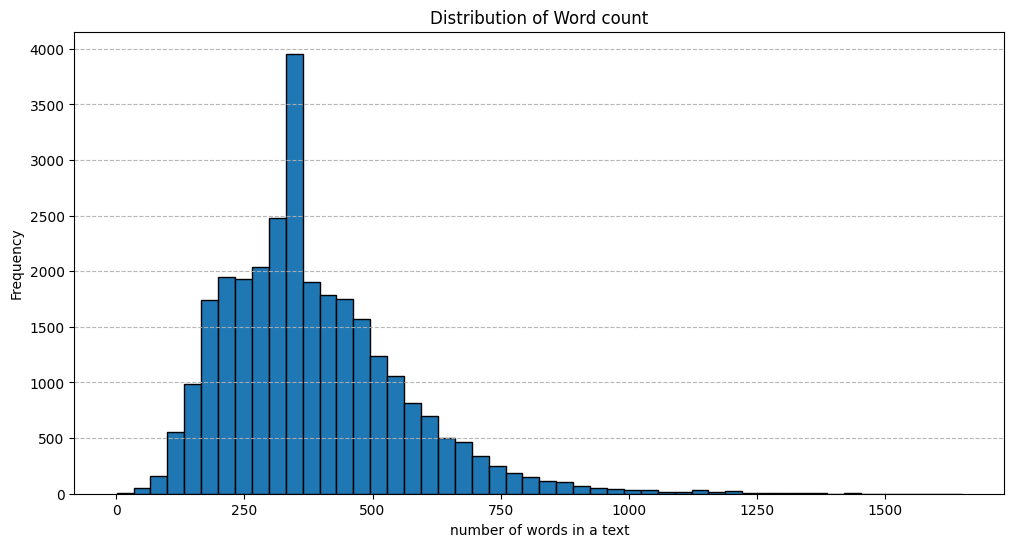

Average word count: 383.14
Median  word count: 351
Minimum word count: 1
Maximum word count: 1650


In [ ]:
# Distribution chart of word counts

# Calculate text lengths
text_lengths = [len(text.split()) for text in df['text']]

# Plot the histogram
plt.figure(figsize=(12, 6))
plt.hist(text_lengths, bins=50,  edgecolor='black')
plt.title('Distribution of Word count')
plt.xlabel('number of words in a text')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.9)
plt.show()

# Print stats
print(f"Average word count: {sum(text_lengths) / len(text_lengths):.2f}")
print(f"Median  word count: {sorted(text_lengths)[len(text_lengths) // 2]}")
print(f"Minimum word count: {min(text_lengths)}")
print(f"Maximum word count: {max(text_lengths)}")

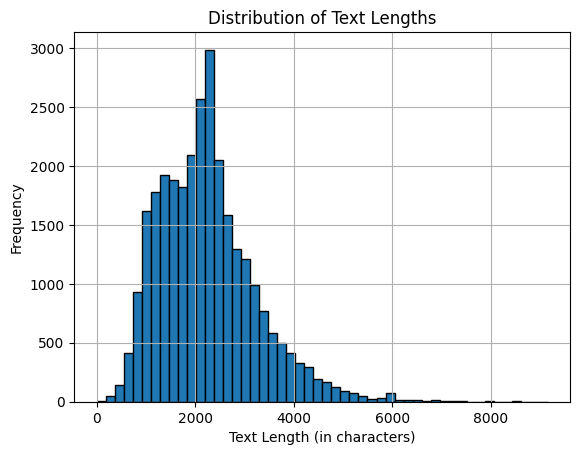

Mean   text length: 2235.996740435752
Median text length: 2158.0
Max    text length: 9157
Min    text length: 1


In [ ]:
# Distribution graph for text lengths

# Calculate the length of each text (in characters)
text_lengths = df['text'].apply(len)
plt.hist(text_lengths, bins=50, edgecolor='black')
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length (in characters)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# print stats
print("Mean   text length:", np.mean(text_lengths))
print("Median text length:", np.median(text_lengths))
print("Max    text length:", np.max(text_lengths))
print("Min    text length:", np.min(text_lengths))

In [ ]:
# Filter texts with word counts between 170 and 500 for an even distribution and helps model for better generalization
filtered_by_word_count_df = df[df['text'].apply(lambda x: 170 <= len(x.split()) <= 500)]

# print the shape of the filtered DataFrame
print(f"Filtered DataFrame shape: {filtered_by_word_count_df.shape}")

Filtered DataFrame shape: (21118, 2)


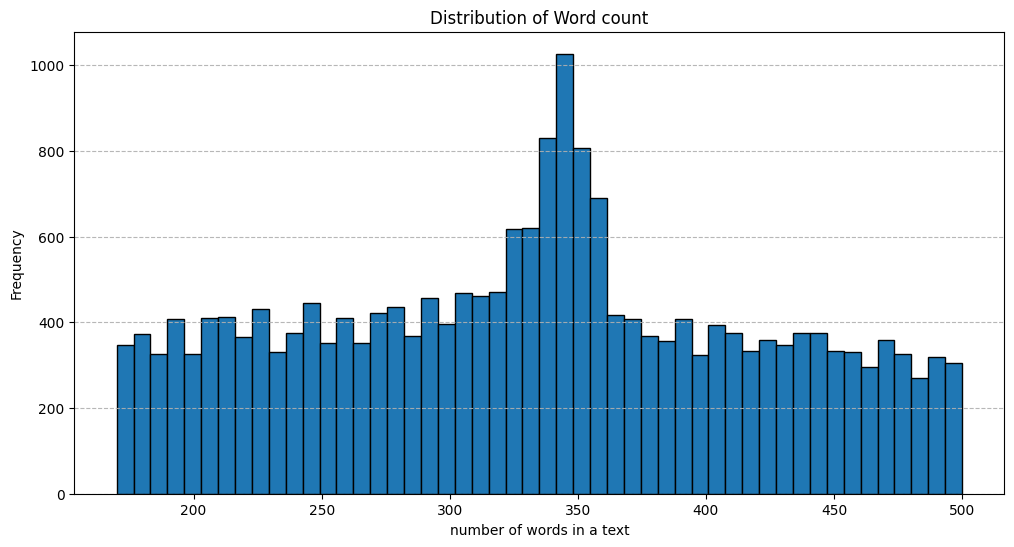

Average word count: 331.64
Median  word count: 336
Minimum word count: 170
Maximum word count: 500


In [ ]:
# Distribution after filtering by word count
text_lengths = [len(text.split()) for text in filtered_by_word_count_df['text']]

plt.figure(figsize=(12, 6))
plt.hist(text_lengths, bins=50,  edgecolor='black')
plt.title('Distribution of Word count')
plt.xlabel('number of words in a text')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.9)
plt.show()

print(f"Average word count: {sum(text_lengths) / len(text_lengths):.2f}")
print(f"Median  word count: {sorted(text_lengths)[len(text_lengths) // 2]}")
print(f"Minimum word count: {min(text_lengths)}")
print(f"Maximum word count: {max(text_lengths)}")

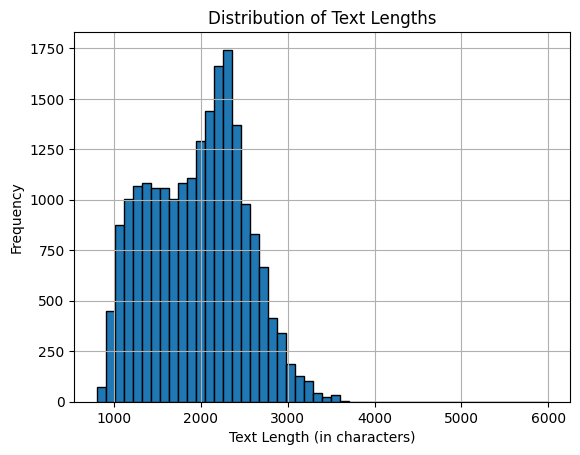

Mean   text length: 1956.1594847996969
Median text length: 2002.0
Max    text length: 5995
Min    text length: 805


In [ ]:
# Distribution of text lengths after filtering by word count
# Calculate the length of each text (in characters)
text_lengths = filtered_by_word_count_df['text'].apply(len)

plt.hist(text_lengths, bins=50, edgecolor='black')
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length (in characters)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# print stats
print("Mean   text length:", np.mean(text_lengths))
print("Median text length:", np.median(text_lengths))
print("Max    text length:", np.max(text_lengths))
print("Min    text length:", np.min(text_lengths))

Number of texts remaining after filtering: 20562


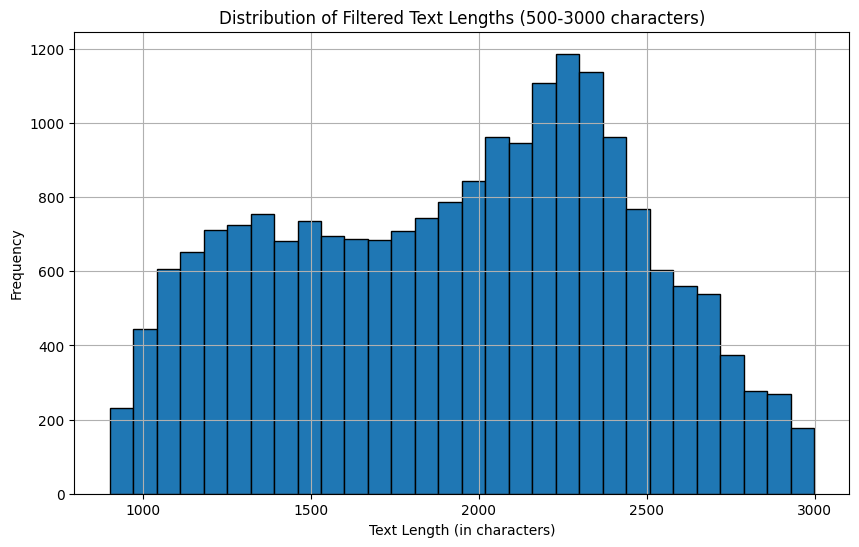

In [ ]:
# Filter the texts based on their length by removing the texts with character lenght below 900 and above 3000 which is good for having an evenly distributed data
filtered_data = filtered_by_word_count_df[(filtered_by_word_count_df['text'].apply(len) >= 900) & (filtered_by_word_count_df['text'].apply(len) <= 3000)]

# number of texts remaining after filtering
print(f"Number of texts remaining after filtering: {len(filtered_data)}")

# Plotting the distribution of filtered text lengths
filtered_text_lengths = filtered_data['text'].apply(len)
plt.figure(figsize=(10, 6))
plt.hist(filtered_text_lengths, bins=30, edgecolor='black')
plt.title('Distribution of Filtered Text Lengths (500-3000 characters)')
plt.xlabel('Text Length (in characters)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

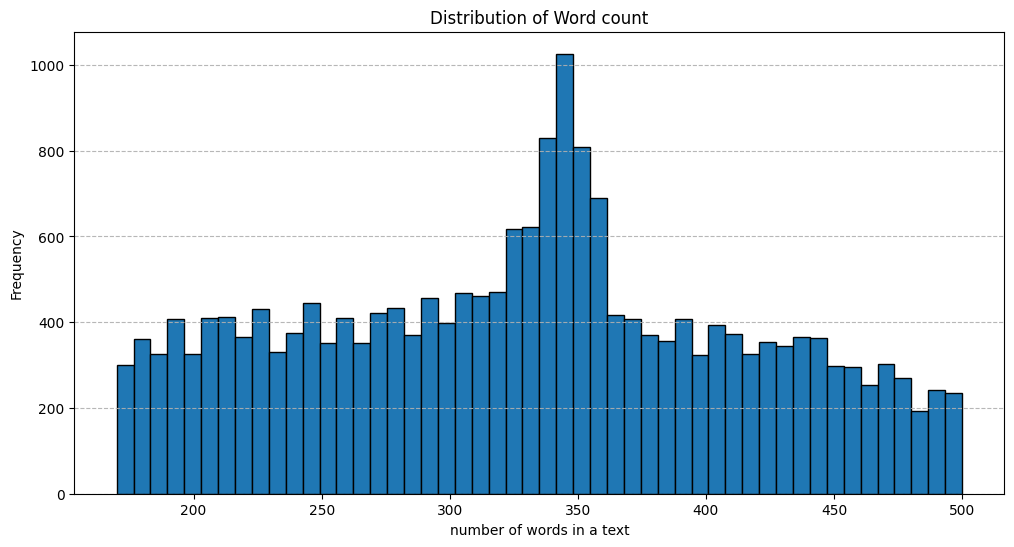

Average word count: 328.73
Median  word count: 334
Minimum word count: 170
Maximum word count: 500


In [ ]:
# Checking the distribution graph again for word count after filtering texts based on the character lenght

# Calculate text lengths
text_lengths = [len(text.split()) for text in filtered_data['text']]

# Plot the histogram
plt.figure(figsize=(12, 6))
plt.hist(text_lengths, bins=50,  edgecolor='black')
plt.title('Distribution of Word count')
plt.xlabel('number of words in a text')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.9)
plt.show()

# Print stats
print(f"Average word count: {sum(text_lengths) / len(text_lengths):.2f}")
print(f"Median  word count: {sorted(text_lengths)[len(text_lengths) // 2]}")
print(f"Minimum word count: {min(text_lengths)}")
print(f"Maximum word count: {max(text_lengths)}")


In [ ]:
filtered_data.shape

(20562, 2)

In [ ]:
df=filtered_data

In [ ]:
# Remove the data samples randomly from Human texts to balance the data
generated_count = df['generated'].sum()
human_indices = df[df['generated'] == 0].index
generated_indices = df[df['generated'] == 1].index

# Convert human indices to a pandas Series and sample the same number as generated
human_sampled_indices = pd.Series(human_indices).sample(n=generated_count, random_state=42)

# Create a new balanced dataframe
balanced_df = pd.concat([df.loc[generated_indices], df.loc[human_sampled_indices]])

# Shuffle the dataframe to mix both samples
balanced_df = shuffle(balanced_df, random_state=42)

# print the new distribution
print('Balanced dataset distribution:')
print(balanced_df['generated'].value_counts())

# reset the index
balanced_df = balanced_df.reset_index(drop=True)


Balanced dataset distribution:
generated
0    8774
1    8774
Name: count, dtype: int64


In [ ]:
#get all words
text=balanced_df.text.values

words=' '.join(text)
words=words.split()

#build vocabulary
vocab = sorted(Counter(words), key=Counter(words).get, reverse=True)
ID2W = dict(enumerate(vocab, 1))
ID2W[0] = '<PAD>' # special word for paddding purpose, and the index is 0
vectorizer = {word: ID for ID, word in ID2W.items()}
vectorizer

{'the': 1,
 'to': 2,
 'and': 3,
 'of': 4,
 'a': 5,
 'is': 6,
 'that': 7,
 'in': 8,
 'for': 9,
 'can': 10,
 'it': 11,
 'be': 12,
 'are': 13,
 'you': 14,
 'on': 15,
 'they': 16,
 'have': 17,
 'or': 18,
 'people': 19,
 'not': 20,
 'their': 21,
 'with': 22,
 'more': 23,
 'as': 24,
 'The': 25,
 'this': 26,
 'we': 27,
 'I': 28,
 'by': 29,
 'would': 30,
 'from': 31,
 'because': 32,
 'In': 33,
 'has': 34,
 'will': 35,
 'an': 36,
 'but': 37,
 'also': 38,
 'if': 39,
 'our': 40,
 'your': 41,
 'about': 42,
 'This': 43,
 'should': 44,
 'there': 45,
 'like': 46,
 'help': 47,
 'could': 48,
 'when': 49,
 'one': 50,
 'make': 51,
 'was': 52,
 'how': 53,
 'students': 54,
 'than': 55,
 'what': 56,
 'many': 57,
 'may': 58,
 'who': 59,
 'all': 60,
 'just': 61,
 'do': 62,
 'other': 63,
 'them': 64,
 'at': 65,
 'car': 66,
 'which': 67,
 'get': 68,
 'so': 69,
 'some': 70,
 'use': 71,
 'It': 72,
 'while': 73,
 'time': 74,
 'think': 75,
 'new': 76,
 'such': 77,
 'vote': 78,
 'better': 79,
 'even': 80,
 'only': 8

In [ ]:
print('Text sample:', text[0])
num_vec = [vectorizer[w] for w in text[0].split()]
print('Coverted vector:',  len(num_vec), num_vec,)

Text sample: Electoral college has helped in many ways. Many people have suggested keeping the electoral college or changing to election by popular vote for the president of United States. I believe that changing to election by popular vote for the president would be best bescause first the more people who vote its easier to determine who would become president and because it will aviod any problems having to choose for president. Changing the election by popular vote can change things in the united states.

Now a days  alot of things have helped the electoral college but in other cases it has not . Changing to election by popular vote can help by choosing the winner and still having its defenders. Also it may help by when they need to find out the winner they know exactly who it is . They can get their election faster and quicker by changing the election vote to the most popular vote for the united states. People still suggest that keeping the electoral college would be better but chn

In [ ]:
#text vectorization and padding

vecs = [[vectorizer[w] for w in r.split()] for r in text]
seq_length=340

X=np.full((len(vecs),seq_length),0,dtype=int)

for i, vec in enumerate(vecs):
    X[i, :len(vec)] = np.array(vec)[:seq_length]

print('Text vectors:', X.shape)
Y = balanced_df.generated.to_numpy()
print('Labels:', Y.shape)

Text vectors: (17548, 340)
Labels: (17548,)


In [ ]:
print('Original vector:', vec[0])
print('Results with padding:', X[0])

Original vector: 1512
Results with padding: [   92   128    34  1328     8    57  1055   356    19    17  5546   834
     1   107   128    18   739     2   263    29   121    78     9     1
   194     4   308   971    28   105     7   739     2   263    29   121
    78     9     1   194    30    12   168 30944   215     1    23    19
    59    78    99   396     2  1544    59    30   143   194     3    32
    11    35 13996   113   438   138     2   373     9   442  5062     1
   263    29   121    78    10   199   125     8     1  1752   825  1160
     5   477   930     4   125    17  1328     1   107   128    37     8
    63  2121    11    34    20   129  5062     2   263    29   121    78
    10    47    29   890     1  1204     3   169   138    99 13074   486
    11    58    47    29    49    16   102     2   187    89     1  1204
    16    90  1628    59    11     6   129   117    10    68    21   263
  1285     3  3807    29   739     1   263    78     2     1   104   121
    78 

In [ ]:
# Split data into train (70%), validation (15%), and test (15%)

X_train,X_temp,Y_train,Y_temp=train_test_split(X,Y,test_size=0.3)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5)

print("Train set:", X_train.shape, Y_train.shape)
print("Validation set:", X_val.shape, Y_val.shape)
print("Test set:", X_test.shape, Y_test.shape)

batch_size = 128

train_data = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.long), torch.tensor(Y_train, dtype=torch.float)), batch_size=batch_size, shuffle=True)
val_data = DataLoader(TensorDataset(torch.tensor(X_val, dtype=torch.long), torch.tensor(Y_val, dtype=torch.float)), batch_size=batch_size)
test_data = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.long), torch.tensor(Y_test, dtype=torch.float)), batch_size=batch_size)

Train set: (12283, 340) (12283,)
Validation set: (2632, 340) (2632,)
Test set: (2633, 340) (2633,)


In [ ]:
vocab_size = len(vectorizer)  # Number of unique words in your vocabulary

embedding_dim = 340

seq_length = 340  # Max sequence length

num_classes = 1



inputs = Input(shape=(seq_length,))
embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=seq_length)(inputs)
cnn = Conv1D(filters=128, kernel_size=5, activation='relu', padding='same')(embedding)
cnn = BatchNormalization()(cnn)
cnn = MaxPooling1D(pool_size=4)(cnn)
cnn = Conv1D(filters=256, kernel_size=3, activation='relu', padding='same')(cnn)
cnn = BatchNormalization()(cnn)
cnn = MaxPooling1D(pool_size=2)(cnn)
lstm = LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)(cnn)
lstm = LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.3)(lstm)
dense = Dense(256, activation='relu')(lstm)
dense = Dropout(0.5)(dense)
dense = Dense(128, activation='relu')(dense)
dense = Dropout(0.5)(dense)
dense = Dense(64, activation='relu')(dense)
outputs = Dense(num_classes, activation='sigmoid')(dense)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 340)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 340, 340)            │      38,910,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 340, 128)            │         217,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 340, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 85, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 85, 256)             │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 85, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 42, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 42, 128)             │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 39,533,169 (150.81 MB)

 Trainable params: 39,532,401 (150.80 MB)

 Non-trainable params: 768 (3.00 KB)

In [ ]:
# Train the model
history = model.fit(train_data, epochs=10, batch_size=batch_size, validation_data=val_data, verbose=1)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 48s 352ms/step - accuracy: 0.7375 - loss: 0.4571 - val_accuracy: 0.4875 - val_loss: 1.0408
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 31s 328ms/step - accuracy: 0.9923 - loss: 0.0283 - val_accuracy: 0.4875 - val_loss: 1.0454
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 32s 335ms/step - accuracy: 0.9988 - loss: 0.0070 - val_accuracy: 0.6159 - val_loss: 0.8037
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 32s 338ms/step - accuracy: 0.9982 - loss: 0.0060 - val_accuracy: 0.8169 - val_loss: 0.3434
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 41s 337ms/step - accuracy: 0.9964 - loss: 0.0113 - val_accuracy: 0.9909 - val_loss: 0.0399
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 32s 338ms/step - accuracy: 0.9993 - loss: 0.0027 - val_accuracy: 0.9886 - val_loss: 0.0489
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 32s 330ms/step - accuracy: 0.9995 - loss: 0.0028 - val_accuracy: 0.9924 - val_loss: 0.0454
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 42s 339ms/step - accuracy: 0.9991 - loss: 0.0045 - val_accu

In [ ]:
# Evaluate the model on the test set

test_loss, test_acc = model.evaluate(test_data)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9961 - loss: 0.0172
Test Loss: 0.028532814234495163
Test Accuracy: 0.9950626492500305


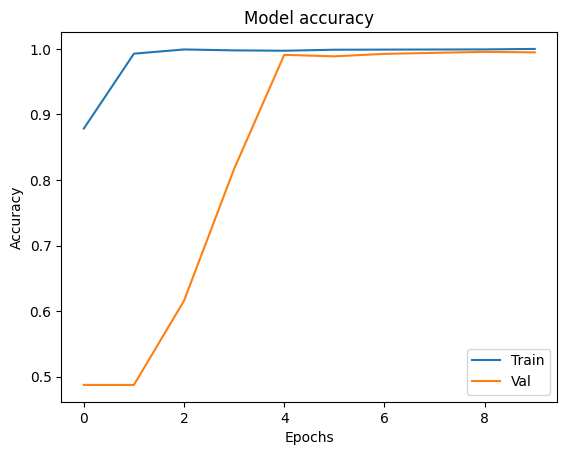

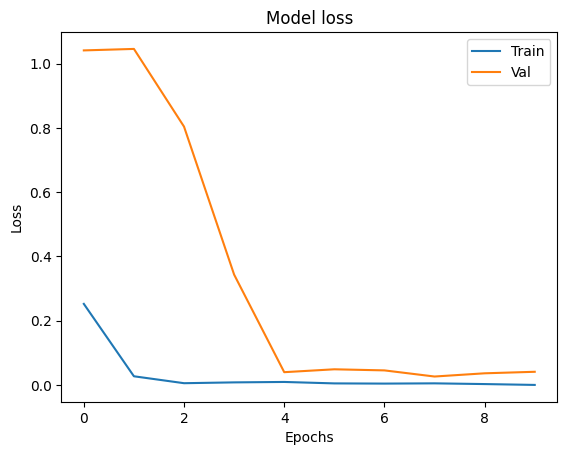

In [ ]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'])
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'])
plt.show()

In [ ]:
# Predict probabilities
y_pred_prob = model.predict(test_data)

# Convert probabilities to binary (0 or 1)
y_pred = (y_pred_prob > 0.5).astype(int)

21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step


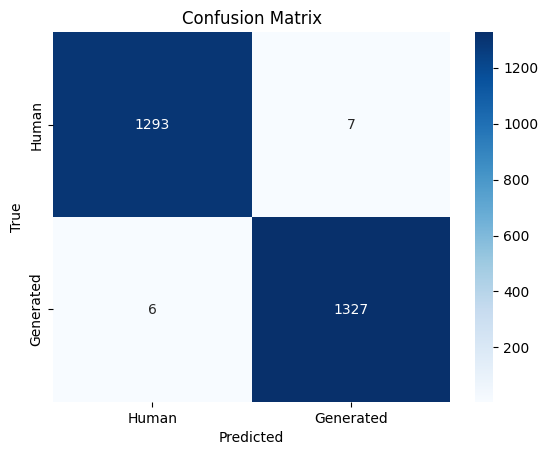

In [ ]:
conf_matrix = confusion_matrix(Y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'Generated'], yticklabels=['Human', 'Generated'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
precision = precision_score(Y_test, y_pred)
print("Precision:", precision)
recall = recall_score(Y_test, y_pred)
print("Recall:", recall)
f1 = f1_score(Y_test, y_pred)
print("F1 Score:", f1)

Precision: 0.9947526236881559
Recall: 0.9954988747186797
F1 Score: 0.9951256092988376


In [ ]:

def preprocess_text(text, vectorizer, seq_length):
    words = text.split()
    vec = [vectorizer.get(word, 0) for word in words]
    vec = vec[:seq_length]
    vec += [0] * (seq_length - len(vec))
    return np.array(vec)

new_text = """I beam, flashing a smile towards the camera of my moms iPhone. In my hand, I grip a fourbythree inch square of plastic that, in my perspective, is synonymous with freedom. Its the moment every kid dreams about, lying bellydown on the kitchen floor and pushing a Barbie jeep around their mothers feet as she labors away at the stove, the stark scent of garlic filling their little noses. Finally, I got my drivers license! While definitely a defining moment of adolescence, most teenagers refuse to acknowledge the degrading qualities of driving. Limiting car usage has a multitude of benefits, such as decreasing air pollution and improving the health and quality of life of the worlds people.

As a new driver, there is nothing I despise more than waking up to severe smog, squinting as I corral my vehicle down blurred roadways en route to school. By utilizing my own vehicle, however, I am adding to the problem. Smog and other forms of unaesthetic air pollution are caused in part by the greenhouse gas emissions from cars tailpipe. In the United States, passenger cars are responsible for up to 50% of greenhouse gas emissions. Source 1 Another large percentage of these emissions comes from the inefficient, energywasting, carbonspewing processes required to create gasoline and diesel fuel. Essentially, we emit large amounts of greenhouse gases to produce fuel for our vehicles which, in turn, release more greenhouse gases. As an AP Environmental Science student, I know better than anyone the degrading results of excessive greenhouse gases. As these particles accumulate in the atmosphere, light from the sun, including harmful ultraviolet rays, stays trapped in our planet, causing a gradual rise in average temperature. This process is known as global warming. Besides being dangerous to our planet, air pollution is unappealing visualy to all inhabitants of Earth. Smog once reached such high levels in Paris, the capital of France, that a partial driving ban was placed on the city to purify the air. After one day of diminishing the number of cars on the roads by 50%, the smog had cleared enough for civilians to continue their daily activities. Source 2 The grotesque images associated with smog can harm Paris economy tourists want to view the Palace of Versailles with a tear in their eye from its beauty, not from the sting of air pollutants.

Limiting car usage also has a variety of physical and psycological benefits that improve the health of earths people. For example, a suburban community in Germany, known as Vauban, has gone completely carfree. 57% of Vaubans residents sold a car to move in and, so far, the majority of them seem to be enjoying the benefits. Heidrun Walker, a media trainer and mother of two, is one of them. When I had a car, I was always tense, she said, Im much happier this way. Source 1 Walkers statement shows the improved psychological wellbeing of those who do not rely on cars for the majority of their transportation. Decreased reliance on motor vehicles can also improve the physical health of humanity. Without personalized vehicles for transportation, many people will walk, jog, bike, or skate to their various destinations. Such a phenomenon occurs annually in Bogota, the capital of Columbia. Every year, they host a Day Without Cars, during which Columbians rely on their own two feet to move about their sprawling city. Source 3 Physical activities such as walking have a variety of benefits, including increased cardiovascular health. If more countries hosted events similar to Bogotas Day Without Cars, emergency rooms may find they have less clogged arteries to deal with.

Limiting car usage has many pros, including decreased air pollution and increased mental and physical wellbeing of the worlds people. The next time you unlock your car to drive two minutes to your friends house, stop and consider the consequences of your actions. Consider the health of yourself and your planet, and try walking instead."""


input_vector = preprocess_text(new_text, vectorizer, seq_length)
input_vector = np.expand_dims(input_vector, axis=0)


In [ ]:
prediction = model.predict(input_vector)
print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
[[8.427099e-06]]


In [ ]:
label = "AI Generated" if prediction[0][0] > 0.5 else "Human"
print(f"Predicted label: {label}")

Predicted label: Human
